<h1> <center> Implementations of our methods <center></h1>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.spatial import cKDTree
import cv2
import SimpleITK as sitk

## Preprocessing

### If you want to save the preprocessed data in order to rerun all the following code, turn the `save` flag to `True`:


In [50]:
save_flag = False

In [87]:
#Define the function that gets the mask from the test image

def get_mask(im):
    """Gets true mask with LV from the test image"""
    if set(im.flatten()) == {0,1,2,3}:
        return im
    if np.sum(im) == 0:
        return im
    tmp = im.copy()
    binary_image = tmp.astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(im,dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    mask = mask-binary_image
    mask = mask > 0
    true_mask = np.zeros_like(im)
    true_mask[mask] = 3
    true_mask[im == 1] = 1
    true_mask[im == 2] = 2
    return true_mask

def get_volume(mat,voxel_volume):
    vols = np.zeros(3)
    for k in range(3):
        vols[k] = np.sum(mat == k+1) * voxel_volume
    return vols

def compute_volume(mask, voxel_volume):
    """Compute volume from a binary mask."""
    return np.sum(mask) * voxel_volume

def compute_ejection_fraction(edv, esv):
    """Compute ejection fraction."""
    return ((edv - esv) / edv) * 100

### Preprocessing the 12 features

In [79]:
df_train = pd.read_csv('./data/metaDataTrain.csv')
df_test = pd.read_csv('./data/metaDataTest.csv')

In [82]:
left_volumes_ED = np.zeros(100)
right_volumes_ED = np.zeros(100)
myo_volumes_ED = np.zeros(100)

left_volumes_ES = np.zeros(100)
right_volumes_ES = np.zeros(100)
myo_volumes_ES = np.zeros(100)

for id in range(1,101):
    #import image at ED
    s = './data/Train/'+str(id).zfill(3)+'/'+str(id).zfill(3)+'_ED_seg.nii'
    im_ED = sitk.ReadImage(s)
    voxel_volume = np.prod(im_ED.GetSpacing())
    im_ED = sitk.GetArrayFromImage(im_ED)
    """ mat = np.zeros(im_ED.shape)
    for k in range(im_ED.shape[0]):
        mat[k] = get_mask(im_ED[k,:,:]) """
    #get volume of each class
    vol_ED = get_volume(im_ED,voxel_volume)  

    #import image at ES
    s = './data/Train/'+str(id).zfill(3)+'/'+str(id).zfill(3)+'_ES_seg.nii'
    im_ES = sitk.ReadImage(s)
    voxel_volume = np.prod(im_ES.GetSpacing())
    im_ES = sitk.GetArrayFromImage(im_ES)
    """ mat = np.zeros(im_ES.shape)
    for k in range(im_ES.shape[0]):
        mat[k] = get_mask(im_ES[k,:,:]) """
    #get volume of each class
    vol_ES = get_volume(im_ES,voxel_volume)

    #store volumes
    left_volumes_ED[id-1] = vol_ED[2]
    right_volumes_ED[id-1] = vol_ED[0]
    myo_volumes_ED[id-1] = vol_ED[1]
    left_volumes_ES[id-1] = vol_ES[2]
    right_volumes_ES[id-1] = vol_ES[0]
    myo_volumes_ES[id-1] = vol_ES[1]


In [83]:
df_train['EDV_LV'] = left_volumes_ED
df_train['EDV_RV'] = right_volumes_ED
df_train['EDV_MYO'] = myo_volumes_ED
df_train['ESV_LV'] = left_volumes_ES
df_train['ESV_RV'] = right_volumes_ES
df_train['ESV_MYO'] = myo_volumes_ES

df_train['MYO_MASS_ES'] = df_train['ESV_MYO'] * 1.05   # 1.05 g/cm^3 is the density of myocardium.
df_train['MYO_MASS_ED'] = df_train['EDV_MYO'] * 1.05   # 1.05 g/cm^3 is the density of myocardium.

In [84]:
left_volumes_ED = np.zeros(50)
right_volumes_ED = np.zeros(50)
myo_volumes_ED = np.zeros(50)

left_volumes_ES = np.zeros(50)
right_volumes_ES = np.zeros(50)
myo_volumes_ES = np.zeros(50)

for id in range(101,151):
    #import image at ED
    s = './data/Test/'+str(id).zfill(3)+'/'+str(id).zfill(3)+'_ED_seg.nii'
    im_ED = sitk.ReadImage(s)
    voxel_volume = np.prod(im_ED.GetSpacing())
    im_ED = sitk.GetArrayFromImage(im_ED)
    mat = np.zeros(im_ED.shape)
    for k in range(im_ED.shape[0]):
        mat[k] = get_mask(im_ED[k,:,:])
    #get volume of each class
    vol_ED = get_volume(mat,voxel_volume)  

    #import image at ES
    s = './data/Test/'+str(id).zfill(3)+'/'+str(id).zfill(3)+'_ES_seg.nii'
    im_ES = sitk.ReadImage(s)
    voxel_volume = np.prod(im_ES.GetSpacing())
    im_ES = sitk.GetArrayFromImage(im_ES)
    mat = np.zeros(im_ES.shape)
    for k in range(im_ES.shape[0]):
        mat[k] = get_mask(im_ES[k,:,:])
    #get volume of each class
    vol_ES = get_volume(mat,voxel_volume)

    #store volumes
    left_volumes_ED[id-101] = vol_ED[2]
    right_volumes_ED[id-101] = vol_ED[0]
    myo_volumes_ED[id-101] = vol_ED[1]
    left_volumes_ES[id-101] = vol_ES[2]
    right_volumes_ES[id-101] = vol_ES[0]
    myo_volumes_ES[id-101] = vol_ES[1]



In [85]:
df_test['EDV_LV'] = left_volumes_ED
df_test['EDV_RV'] = right_volumes_ED
df_test['EDV_MYO'] = myo_volumes_ED
df_test['ESV_LV'] = left_volumes_ES
df_test['ESV_RV'] = right_volumes_ES
df_test['ESV_MYO'] = myo_volumes_ES

df_test['MYO_MASS_ES'] = df_test['ESV_MYO'] * 1.05   # 1.05 g/cm^3 is the density of myocardium.
df_test['MYO_MASS_ED'] = df_test['EDV_MYO'] * 1.05   # 1.05 g/cm^3 is the density of myocardium.

In [ ]:
if save_flag:
    df_train.to_csv('./data/12_features.csv',index=False)
    df_test.to_csv('./data/12_features_test.csv',index=False)

### Preprocessing of the 14 features dataset

In [88]:
df_train = pd.read_csv('./data/metaDataTrain.csv')
df_test = pd.read_csv('./data/metaDataTest.csv')

In [89]:
lv_edv_tab = []
lv_esv_tab = []
rv_edv_tab = []
rv_esv_tab = []
myo_edv_tab = []
myo_esv_tab = []
lv_ef_tab = []
rv_ef_tab = []
rv_lv_ratio_ed_tab = []
rv_lv_ratio_es_tab = []
myo_lv_ratio_ed_tab = []
myo_lv_ratio_es_tab = []


for i in range(1,101):
    s = './data/Train/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ED_seg.nii'
    img = sitk.ReadImage(s)
    voxel_volume_ed = np.prod(img.GetSpacing())
    img = sitk.GetArrayFromImage(img)
    lv_ed_mask = img == 3
    rv_ed_mask = img == 1
    myo_ed_mask = img == 2

    s = './data/Train/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ES_seg.nii'
    img = sitk.ReadImage(s)
    voxel_volume_es = np.prod(img.GetSpacing())
    img = sitk.GetArrayFromImage(img)
    lv_es_mask = img == 3
    rv_es_mask = img == 1
    myo_es_mask = img == 2

    lv_edv = compute_volume(lv_ed_mask, voxel_volume_ed)  # LV end-diastole volume (ml)
    lv_esv = compute_volume(lv_es_mask, voxel_volume_es)  # LV end-systole volume (ml)
    rv_edv = compute_volume(rv_ed_mask, voxel_volume_ed)  # RV end-diastole volume (ml)
    rv_esv = compute_volume(rv_es_mask, voxel_volume_es)  # RV end-systole volume (ml)
    myo_edv = compute_volume(myo_ed_mask, voxel_volume_ed)  # Myo end-diastole volume (ml)
    myo_esv = compute_volume(myo_es_mask, voxel_volume_es)  # Myo end-systole volume (ml)

    lv_ef = compute_ejection_fraction(lv_edv, lv_esv)  # LV ejection fraction
    rv_ef = compute_ejection_fraction(rv_edv, rv_esv)  # RV ejection fraction

    rv_lv_ratio_ed = rv_edv / lv_edv  # Ratio of RV to LV volume at end-diastole
    rv_lv_ratio_es = rv_esv / lv_esv  # Ratio of RV to LV volume at end-systole
    myo_lv_ratio_ed = myo_edv / lv_edv  # Ratio of myocardial to LV volume at end-diastole
    myo_lv_ratio_es = myo_esv / lv_esv  # Ratio of myocardial to LV volume at end-systole

    lv_edv_tab.append(lv_edv)
    lv_esv_tab.append(lv_esv)
    rv_edv_tab.append(rv_edv)
    rv_esv_tab.append(rv_esv)
    myo_edv_tab.append(myo_edv)
    myo_esv_tab.append(myo_esv)
    lv_ef_tab.append(lv_ef)
    rv_ef_tab.append(rv_ef)
    rv_lv_ratio_ed_tab.append(rv_lv_ratio_ed)
    rv_lv_ratio_es_tab.append(rv_lv_ratio_es)
    myo_lv_ratio_ed_tab.append(myo_lv_ratio_ed)
    myo_lv_ratio_es_tab.append(myo_lv_ratio_es)

df_train['EDV LV'] = lv_edv_tab
df_train['ESV LV'] = lv_esv_tab
df_train['EDV RV'] = rv_edv_tab
df_train['ESV RV'] = rv_esv_tab
df_train['EDV Myo'] = myo_edv_tab
df_train['ESV Myo'] = myo_esv_tab
df_train['EF LV'] = lv_ef_tab
df_train['EF RV'] = rv_ef_tab
df_train['RV/LV ED'] = rv_lv_ratio_ed_tab
df_train['RV/LV ES'] = rv_lv_ratio_es_tab
df_train['Myo/LV ED'] = myo_lv_ratio_ed_tab
df_train['Myo/LV ES'] = myo_lv_ratio_es_tab

In [90]:
lv_edv_tab = []
lv_esv_tab = []
rv_edv_tab = []
rv_esv_tab = []
myo_edv_tab = []
myo_esv_tab = []
lv_ef_tab = []
rv_ef_tab = []
rv_lv_ratio_ed_tab = []
rv_lv_ratio_es_tab = []
myo_lv_ratio_ed_tab = []
myo_lv_ratio_es_tab = []


for i in range(101,151):
    s = './data/Test/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ED_seg.nii'
    img = sitk.ReadImage(s)
    voxel_volume_ed = np.prod(img.GetSpacing())
    img = sitk.GetArrayFromImage(img)
    mat = np.zeros(img.shape)
    for k in range(img.shape[0]):
        mat[k] = get_mask(img[k,:,:])
    lv_ed_mask = mat == 3
    rv_ed_mask = mat == 1
    myo_ed_mask = mat == 2  

    s = './data/Test/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ES_seg.nii'
    img = sitk.ReadImage(s)
    voxel_volume_es = np.prod(img.GetSpacing())
    img = sitk.GetArrayFromImage(img)
    mat = np.zeros(img.shape)
    for k in range(img.shape[0]):
        mat[k] = get_mask(img[k,:,:])
    lv_es_mask = mat == 3
    rv_es_mask = mat == 1
    myo_es_mask = mat == 2

    if voxel_volume_ed != voxel_volume_es:
        print('Error at ',i)

    lv_edv = compute_volume(lv_ed_mask, voxel_volume_ed)  # LV end-diastole volume (ml)
    lv_esv = compute_volume(lv_es_mask, voxel_volume_es)  # LV end-systole volume (ml)
    rv_edv = compute_volume(rv_ed_mask, voxel_volume_ed)  # RV end-diastole volume (ml)
    rv_esv = compute_volume(rv_es_mask, voxel_volume_es)  # RV end-systole volume (ml)
    myo_edv = compute_volume(myo_ed_mask, voxel_volume_ed)  # Myo end-diastole volume (ml)
    myo_esv = compute_volume(myo_es_mask, voxel_volume_es)  # Myo end-systole volume (ml)

    lv_ef = compute_ejection_fraction(lv_edv, lv_esv)  # LV ejection fraction
    rv_ef = compute_ejection_fraction(rv_edv, rv_esv)  # RV ejection fraction

    rv_lv_ratio_ed = rv_edv / lv_edv  # Ratio of RV to LV volume at end-diastole
    rv_lv_ratio_es = rv_esv / lv_esv  # Ratio of RV to LV volume at end-systole
    myo_lv_ratio_ed = myo_edv / lv_edv  # Ratio of myocardial to LV volume at end-diastole
    myo_lv_ratio_es = myo_esv / lv_esv  # Ratio of myocardial to LV volume at end-systole

    lv_edv_tab.append(lv_edv)
    lv_esv_tab.append(lv_esv)
    rv_edv_tab.append(rv_edv)
    rv_esv_tab.append(rv_esv)
    myo_edv_tab.append(myo_edv)
    myo_esv_tab.append(myo_esv)
    lv_ef_tab.append(lv_ef)
    rv_ef_tab.append(rv_ef)
    rv_lv_ratio_ed_tab.append(rv_lv_ratio_ed)
    rv_lv_ratio_es_tab.append(rv_lv_ratio_es)
    myo_lv_ratio_ed_tab.append(myo_lv_ratio_ed)
    myo_lv_ratio_es_tab.append(myo_lv_ratio_es)

df_test['EDV LV'] = lv_edv_tab
df_test['ESV LV'] = lv_esv_tab
df_test['EDV RV'] = rv_edv_tab
df_test['ESV RV'] = rv_esv_tab
df_test['EDV Myo'] = myo_edv_tab
df_test['ESV Myo'] = myo_esv_tab
df_test['EF LV'] = lv_ef_tab
df_test['EF RV'] = rv_ef_tab
df_test['RV/LV ED'] = rv_lv_ratio_ed_tab
df_test['RV/LV ES'] = rv_lv_ratio_es_tab
df_test['Myo/LV ED'] = myo_lv_ratio_ed_tab
df_test['Myo/LV ES'] = myo_lv_ratio_es_tab

In [ ]:
if save_flag:
    df_train.to_csv('./data/14_features_train.csv')
    df_test.to_csv('./data/14_features_test.csv')

### Preprocessing for the 20 features dataset
```python

In [48]:
data_train = pd.read_csv('./data/14_features_train.csv')
data_test = pd.read_csv('./data/14_features_test.csv')

new_data_train = data_train.copy()
new_data_test = data_test.copy()

In [ ]:
# define functions to get the new fatures 

def compute_slice_mwt_stats(mask_slice, pixel_spacing):
    # Binary masks
    lvc = (mask_slice == 1).astype(np.uint8)
    lvm = (mask_slice == 2).astype(np.uint8)
    
    # Find contours
    cnts_lvc, _ = cv2.findContours(lvc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts_lvm, _ = cv2.findContours(lvm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts_lvc or not cnts_lvm:
        return None, None
    
    # Flatten contour points
    pts_inner = np.vstack(cnts_lvc).squeeze(axis=1)  # inner boundary (LVC)
    pts_outer = np.vstack(cnts_lvm).squeeze(axis=1)  # outer boundary (LVM)
    
    # Nearest‐neighbor distances
    tree = cKDTree(pts_outer)
    dists, _ = tree.query(pts_inner)  # distance in pixels
    thickness_mm = dists * pixel_spacing  # convert to mm
    
    return thickness_mm.mean(), thickness_mm.std()

def extract_mwt_variation_features(mask_ed, mask_es, pixel_spacing, excluded_slice_ratio=0.2):
    S = mask_ed.shape[0]
    # Determine slices with LVC presence
    has_lvc = (mask_ed == 1).reshape(S, -1).any(axis=1)
    first = np.argmax(has_lvc)
    last  = S - 1 - np.argmax(has_lvc[::-1])
    R = last - first + 1
    start = first + int(round(R * excluded_slice_ratio * 0.5))
    end   = last + 1 - int(round(R * excluded_slice_ratio * 1.0))
    
    mean_ed, std_ed = [], []
    mean_es, std_es = [], []
    
    for s in range(start, end):
        m, sd = compute_slice_mwt_stats(mask_ed[s], pixel_spacing)
        if m is not None:
            mean_ed.append(m)
            std_ed.append(sd)
        m, sd = compute_slice_mwt_stats(mask_es[s], pixel_spacing)
        if m is not None:
            mean_es.append(m)
            std_es.append(sd)
    
    # Convert to numpy arrays for statistics
    med = np.array(mean_ed)
    sed = np.array(std_ed)
    mes = np.array(mean_es)
    ses = np.array(std_es)
    
    features = {
        'MWT_ED_mean_max':  np.max(med),
        'MWT_ED_mean_std':  np.std(med),
        'MWT_ED_std_mean':  np.mean(sed),
        'MWT_ED_std_std':   np.std(sed),
        'MWT_ES_mean_max':  np.max(mes),
        'MWT_ES_mean_std':  np.std(mes),
        'MWT_ES_std_mean':  np.mean(ses),
        'MWT_ES_std_std':   np.std(ses),
    }
    return features

In [ ]:
MWT_ED_mean_max = []
MWT_ED_mean_std = []
MWT_ED_std_mean = []
MWT_ED_std_std = []
MWT_ES_mean_max = []
MWT_ES_mean_std = []
MWT_ES_std_mean = []
MWT_ES_std_std = []


for i in range(1,101):
    s = './data/Train/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ED_seg.nii'
    mask_ed = sitk.GetArrayFromImage(sitk.ReadImage(s))
    s = './data/Train/'+str(i).zfill(3)+'/'+str(i).zfill(3)+'_ES_seg.nii'
    mask_es = sitk.GetArrayFromImage(sitk.ReadImage(s))
    pixel_spacing = sitk.ReadImage(s).GetSpacing()[0]  # mm per pixel

    fts = extract_mwt_variation_features(mask_ed, mask_es, pixel_spacing)
    MWT_ED_mean_max.append(fts['MWT_ED_mean_max'])
    MWT_ED_mean_std.append(fts['MWT_ED_mean_std'])
    MWT_ED_std_mean.append(fts['MWT_ED_std_mean'])
    MWT_ED_std_std.append(fts['MWT_ED_std_std'])
    MWT_ES_mean_max.append(fts['MWT_ES_mean_max'])
    MWT_ES_mean_std.append(fts['MWT_ES_mean_std'])
    MWT_ES_std_mean.append(fts['MWT_ES_std_mean'])
    MWT_ES_std_std.append(fts['MWT_ES_std_std'])

new_data_train['MWT_ED_mean_max'] = MWT_ED_mean_max
new_data_train['MWT_ED_mean_std'] = MWT_ED_mean_std
new_data_train['MWT_ED_std_mean'] = MWT_ED_std_mean
new_data_train['MWT_ED_std_std'] = MWT_ED_std_std
new_data_train['MWT_ES_mean_max'] = MWT_ES_mean_max
new_data_train['MWT_ES_mean_std'] = MWT_ES_mean_std
new_data_train['MWT_ES_std_mean'] = MWT_ES_std_mean
new_data_train['MWT_ES_std_std'] = MWT_ES_std_std


In [53]:
#preprocessing of test data

MWT_ED_mean_max = []
MWT_ED_mean_std = []
MWT_ED_std_mean = []
MWT_ED_std_std = []
MWT_ES_mean_max = []
MWT_ES_mean_std = []
MWT_ES_std_mean = []
MWT_ES_std_std = []

for i in range(101,151):
    #import image at ED
    s = './data/Test/'+str(i)+'/'+str(i)+'_ED_seg.nii'
    im_ED = sitk.ReadImage(s)
    spacing = im_ED.GetSpacing()[0]  # mm per pixel
    im_ED = sitk.GetArrayFromImage(im_ED)
    mask_ed = np.zeros(im_ED.shape)
    for k in range(im_ED.shape[0]):
        mask_ed[k] = get_mask(im_ED[k,:,:])

    #import image at ES
    s = './data/Test/'+str(i)+'/'+str(i)+'_ES_seg.nii'
    im_ES = sitk.ReadImage(s)
    im_ES = sitk.GetArrayFromImage(im_ES)
    mask_es = np.zeros(im_ES.shape)
    for k in range(im_ES.shape[0]):
        mask_es[k] = get_mask(im_ES[k,:,:])

    #compute features
    fts = extract_mwt_variation_features(mask_ed, mask_es, spacing)
    MWT_ED_mean_max.append(fts['MWT_ED_mean_max'])
    MWT_ED_mean_std.append(fts['MWT_ED_mean_std'])
    MWT_ED_std_mean.append(fts['MWT_ED_std_mean'])
    MWT_ED_std_std.append(fts['MWT_ED_std_std'])
    MWT_ES_mean_max.append(fts['MWT_ES_mean_max'])
    MWT_ES_mean_std.append(fts['MWT_ES_mean_std'])
    MWT_ES_std_mean.append(fts['MWT_ES_std_mean'])
    MWT_ES_std_std.append(fts['MWT_ES_std_std'])

new_data_test['MWT_ED_mean_max'] = MWT_ED_mean_max
new_data_test['MWT_ED_mean_std'] = MWT_ED_mean_std
new_data_test['MWT_ED_std_mean'] = MWT_ED_std_mean
new_data_test['MWT_ED_std_std'] = MWT_ED_std_std
new_data_test['MWT_ES_mean_max'] = MWT_ES_mean_max
new_data_test['MWT_ES_mean_std'] = MWT_ES_mean_std
new_data_test['MWT_ES_std_mean'] = MWT_ES_std_mean
new_data_test['MWT_ES_std_std'] = MWT_ES_std_std


In [ ]:
if save_flag:
    new_data_train.to_csv('./data/20_features_train.csv', index=False)
    new_data_test.to_csv('./data/20_features_test.csv', index=False)

---


## First Implementation (12 features)

In [4]:
data_train = pd.read_csv('data/12_features.csv')
data_test = pd.read_csv('data/12_features_test.csv')

X_train = data_train.drop(columns=['Category'])
y_train = data_train['Category']

X_test = data_test.copy()

Accuracy on validation set: 0.9666666666666667


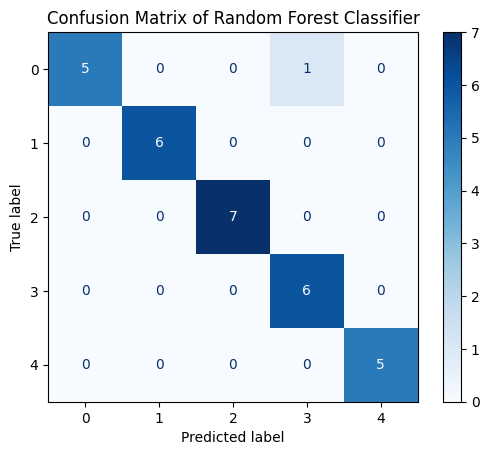

In [21]:
rf = RandomForestClassifier(n_estimators=1000,random_state=42, n_jobs=-1)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

rf.fit(X_t, y_t)
y_pred = rf.predict(X_val)

print("Accuracy on validation set:", accuracy_score(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

We obtain a highly performant classifier without even trying optimization. But it seems that it is overfitting as ewplained in the report.



---


## Second Implementation (14 features)

In [22]:
data_train = pd.read_csv('./data/14_features_train.csv')

X_train = data_train.drop(columns=['Category','Id'])
y_train = data_train['Category']

LogisticRegression - Mean accuracy: 0.8700 ± 0.0678
SVC - Mean accuracy: 0.8700 ± 0.0510
RandomForest - Mean accuracy: 0.9400 ± 0.0200
GradientBoosting - Mean accuracy: 0.8400 ± 0.0583
KNeighbors - Mean accuracy: 0.8600 ± 0.0663
MLP - Mean accuracy: 0.8000 ± 0.0632
GaussianNB - Mean accuracy: 0.9000 ± 0.0548


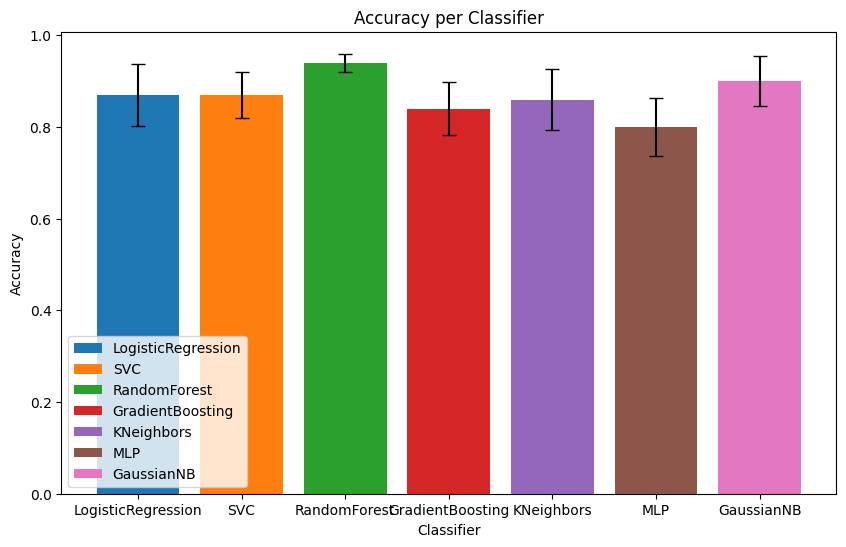

In [27]:
classifiers = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
    'SVC': SVC(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=42),
    'GaussianNB': GaussianNB()
}



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name} - Mean accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    
    plt.bar(name, scores.mean(), yerr=scores.std(), capsize=5, label=name)

    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Classifier')
    plt.legend()
plt.show()

In [28]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.96


As explained in the report, we reached a 96% accuracy on training test with a Random Forest classifier after optimization. But it is once again overfitting. We can see that the accuracy on the test set dropped when we submitted a prediction from this optimized model. For the following, the RF model will be trained with 14 features but with 80% of our training set. We will use the remaining 20% to test the model and see if it is overfitting or not.





---

## Implemention of Khened's paper

In [57]:
data_train = pd.read_csv('./data/20_features.csv')
data_test = pd.read_csv('./data/20_features_test.csv')

X_train = data_train.drop(columns=['Category'])
y_train = data_train['Category']

X_test = data_test.copy()

### Defining all the classifiers for the Voting Classifier

In [59]:
svm = make_pipeline(
    PCA(n_components=15, random_state=42),
    SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
)
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.01, 0.001],
    'svc__kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

svm = grid_search.best_estimator_
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm, X_train, y_train, cv=cv, scoring='accuracy')
print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.900
5‐fold CV accuracy: 0.930 ± 0.040


In [60]:
from sklearn.preprocessing import MinMaxScaler

mlp = make_pipeline(
    MinMaxScaler(),
    MLPClassifier(
        hidden_layer_sizes=(100,100),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size="auto",
        learning_rate="constant",
        learning_rate_init=1e-3,
        max_iter=500,
        random_state=42,
        verbose=False
    )
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring="accuracy")
print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


5‐fold CV accuracy: 0.910 ± 0.037


In [61]:
gnb = make_pipeline(
    PCA(n_components=15, random_state=42),
    GaussianNB()
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(gnb, X_train, y_train, cv=cv, scoring="accuracy")
print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

5‐fold CV accuracy: 0.940 ± 0.049


In [62]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000,max_depth=None,random_state=42))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


5‐fold CV accuracy: 0.960 ± 0.020


Voting Classifier accuracy: 0.967


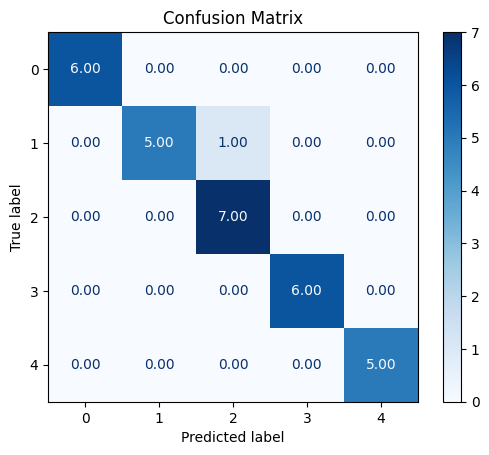

In [64]:
from sklearn.ensemble import VotingClassifier
# Create the VotingClassifier

classifiers = [
    ('RandomForest', pipeline),  # Random Forest
    ('SVC', svm),  # Support Vector Machine
    ('MLP', mlp),  # Multi-Layer Perceptron
    ('GaussianNB', gnb)   # Gaussian Naive Bayes
]

voting_clf = VotingClassifier(estimators=classifiers, voting='hard')

X_train2 , X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

voting_clf.fit(X_train2, y_train2)
y_pred = voting_clf.predict(X_test2)

print(f"Voting Classifier accuracy: {accuracy_score(y_test2, y_pred):.3f}")
cm = confusion_matrix(y_test2, y_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

### Define stage 2 model

In [65]:

#define data for stage 2
x = data_train.copy()
y = x['Category']

es_feats = [
    'Category',
      'MWT_ES_mean_max','MWT_ES_mean_std',
      'MWT_ES_std_mean','MWT_ES_std_std'
    ]

x.head()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


X_train_stage1 = X_train.copy()
X_test_stage1 = X_test.copy()

y_train_stage1 = y_train.copy()
y_test_stage1 = y_test.copy()

X_train_stage1.drop(columns=['Category'], inplace=True)
X_test_stage1.drop(columns=['Category'], inplace=True)

X_train_stage2 = X_train[es_feats].copy()
X_test_stage2 = X_test[es_feats].copy()

X_train_stage2.head() 


X_train_stage2 = X_train_stage2[X_train_stage2['Category'].isin([1, 2])].copy()
X_test_stage2 = X_test_stage2[X_test_stage2['Category'].isin([1, 2])].copy()

y_train_stage2 = y_train_stage1[y_train_stage1.isin([1, 2])].copy()
y_test_stage2 = y_test_stage1[y_test_stage1.isin([1, 2])].copy()

X_train_stage2.drop(columns=['Category'], inplace=True)
X_test_stage2.drop(columns=['Category'], inplace=True) 

X_test.drop(columns=['Category'], inplace=True)




Stage 2 train accuracy: 0.741
Stage 2 test accuracy: 0.692


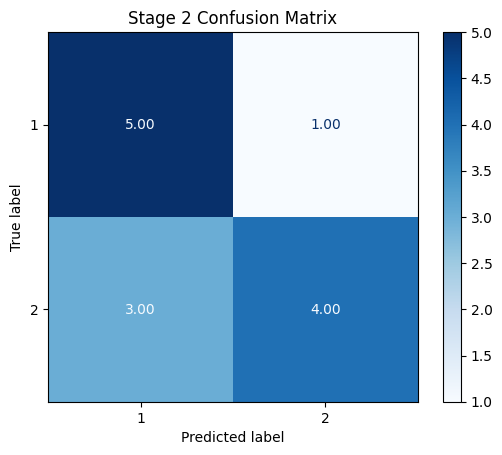

In [70]:
stage2_model = MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100),
                learning_rate_init=0.001, max_iter=500, random_state=42,
                validation_fraction=0.2,alpha=20)

stage2_model.fit(X_train_stage2, y_train_stage2)
print(f"Stage 2 train accuracy: {accuracy_score(y_train_stage2, stage2_model.predict(X_train_stage2)):.3f}")

# Now, for a new patient:
pred_stage2 = stage2_model.predict(X_test_stage2)
print(f"Stage 2 test accuracy: {accuracy_score(y_test_stage2, pred_stage2):.3f}")
cm = confusion_matrix(y_test_stage2, pred_stage2, labels=[1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Stage 2 Confusion Matrix')
plt.show()

In [68]:
def predict_khened(X,stage1,stage2):
    stg1_pred = stage1.predict(X)

    fts = [
        'MWT_ES_mean_max', 'MWT_ES_mean_std',
        'MWT_ES_std_mean', 'MWT_ES_std_std'
    ]

    X_stage2 = X[fts].copy()
    final_preds = stg1_pred.copy()
    for i, pred in enumerate(stg1_pred):
        if pred in (2, 1):
            feature_row = X_stage2.iloc[i]
            pred_stage2 = stage2.predict([feature_row])
            final_preds[i] = pred_stage2[0]
    
    return final_preds



Stage 1 train accuracy: 0.957
Stage 2 train accuracy: 0.741


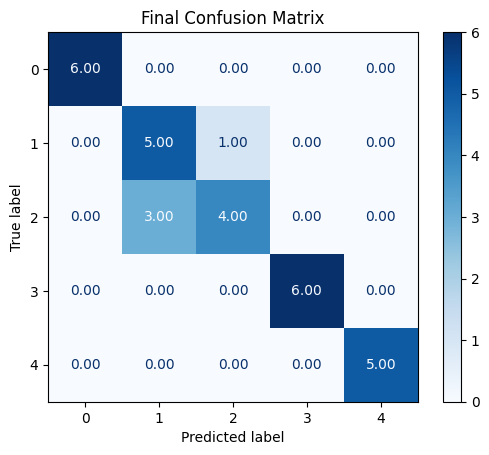

Final Test accuracy: 0.87


In [72]:
import warnings

stage1_model = voting_clf

stage1_model.fit(X_train_stage1, y_train)
stage2_model.fit(X_train_stage2, y_train_stage2)
print(f"Stage 1 train accuracy: {accuracy_score(y_train, stage1_model.predict(X_train_stage1)):.3f}")
print(f"Stage 2 train accuracy: {accuracy_score(y_train_stage2, stage2_model.predict(X_train_stage2)):.3f}")

#for a new patient

warnings.filterwarnings('ignore')

final_preds = predict_khened(X_test, stage1_model, stage2_model)

cm = confusion_matrix(y_test, final_preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Final Confusion Matrix')
plt.show()

print(f'Final Test accuracy: {accuracy_score(y_test, final_preds):.2f}')

The result has worsened with the second stage model.


---

## Best method inspired by Khened's paper



In [120]:
data_train = pd.read_csv('data/14_features_train.csv')
data_test = pd.read_csv('data/14_features_test.csv')

data_train.drop(columns=['Id'],inplace=True)
data_test.drop(columns=['Id'],inplace=True)

X_train = data_train.drop(columns=['Category'])
y_train = data_train['Category']

X_test = data_test

##### First stage model: Random Forest

In [121]:
pip = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
    )
)

cv = cross_validate(
    pip,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    return_train_score=False,
    return_estimator=True,
)

scores = cv['test_score']
rf = cv['estimator'][0]

print(f"Random Forest Classifier Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Random Forest Classifier Accuracy: 0.94 ± 0.04


In [122]:
X_t , X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

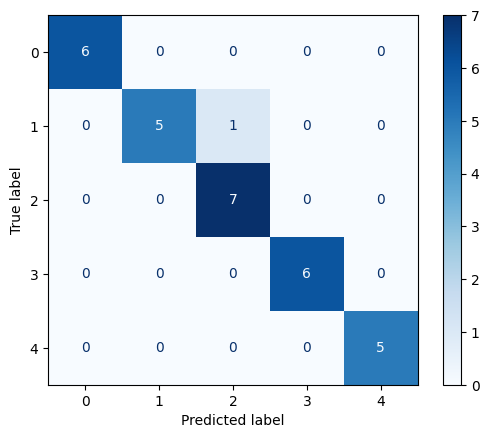

In [123]:
rf.fit(X_t, y_t)

cm = confusion_matrix(y_v, rf.predict(X_v))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

The model is doing great on our training/validating data but as explained in the paper, it is not generalizing well to the test data. We might need refinement of class 1 vs class 2.

##### 2nd stage model

In [124]:
# prepare data for binary classification

df2 = data_train[data_train['Category'].isin([1, 2])]
X2 = df2.drop(columns=['Category'])
y2 = (df2['Category'] == 1).astype(int).values  # 1=MINF, 0=DCM

features = ['ESV LV', 'EDV Myo', 'ESV Myo', 'ESV RV']
X2 = X2[features].values



candidates = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,min_samples_split=2),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100),
              learning_rate_init=0.01, max_iter=1000, random_state=42,
              validation_fraction=0.2),
    'GaussianNB': GaussianNB()
}

for name, model in candidates.items():
    score = cross_val_score(model, X2, y2, cv=5, scoring='accuracy')
    print(f"{name}: {score.mean():.2f} ± {score.std():.2f}")



Logistic Regression: 0.82 ± 0.10
SVC: 0.90 ± 0.05
Random Forest: 0.88 ± 0.08
Gradient Boosting: 0.80 ± 0.10
KNN: 0.90 ± 0.09
MLP: 0.72 ± 0.12
GaussianNB: 0.90 ± 0.05


In [ ]:


X2_raw = data_train[data_train['Category'].isin([1, 2])]
y2_raw = (X2_raw['Category'] == 1).astype(int).values  # 1=MINF, 0=DCM
X2_raw = X2_raw.drop(columns=['Category'])

features_set = ['ESV LV', 'EDV Myo', 'ESV Myo', 'ESV RV']

# Define parameter search spaces for models with score < 0.85
search_spaces = {
    'MLP': {
        'alpha': Real(1e-4, 1e-2, prior='log-uniform'),
        'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
    },
    'LogisticRegression': {
        'C': Real(1e-4, 1e2, prior='log-uniform'),
    },
    'Gradient Boosting': {
        'n_estimators': Integer(50, 200),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'max_depth': Integer(1, 10)
    }
}

# Initialize models
models = {
    'MLP': candidates['MLP'],
    'LogisticRegression': candidates['Logistic Regression'],
    'Gradient Boosting': candidates['Gradient Boosting'],
}

# Perform Bayesian search for each model
results = {}
for name, model in models.items():
   
    search = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces[name],
        n_iter=30,
        cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X2_raw[features_set], y2_raw)
    results[name] = {
        'best_score': search.best_score_,
        'best_params': search.best_params_,
        'best_estimator': search.best_estimator_
    }
    print(f"{name} Best Score: {search.best_score_:.2f}")

    print(f"{name} Best Params: {search.best_params_}")

MLP Best Score: 0.82
MLP Best Params: OrderedDict([('alpha', 0.01), ('learning_rate_init', 0.0027688415809934814)])
LogisticRegression Best Score: 0.90
LogisticRegression Best Params: OrderedDict([('C', 0.028881766539144718)])
Gradient Boosting Best Score: 0.93
Gradient Boosting Best Params: OrderedDict([('learning_rate', 0.0168380325484179), ('max_depth', 1), ('n_estimators', 89)])


MLP seems to be doing worse than the other models but we will still submit it and see how it performs on the test data.

In [ ]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.3, random_state=42)

#pplying parameters from the best models
xgb = GradientBoostingClassifier(n_estimators=89, learning_rate=0.017, max_depth=1, random_state=42)
lr = LogisticRegression(C=0.029, max_iter=1000, random_state=42)
mlp = MLPClassifier(alpha=0.01, learning_rate_init=0.0028, max_iter=1000,hidden_layer_sizes=(100,100),
                    early_stopping=True,validation_fraction=0.2, random_state=42)

xgb.fit(X2, y2)
lr.fit(X2, y2)
mlp.fit(X2, y2)


MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(100, 100),
              learning_rate_init=0.0028, max_iter=1000, random_state=42,
              validation_fraction=0.2)

In [127]:
def refine_labels(y,model,X_test):
    tmp = y.copy()
    for i in range(len(tmp)):
        y_val = tmp[i]
        if y_val in [1, 2]:
            pred_val = model.predict(X_test.iloc[i].values.reshape(1, -1))[0]
            if pred_val == 1:
                tmp[i] = 1
            else:
                tmp[i] = 2
    return tmp
   

In [128]:
def predict_2stage(model, data_train, data_test,features=None):
    #create our data
    X_train = data_train.drop(columns=['Category'])
    y_train = data_train['Category']

    X_test = data_test.copy()

    #fit first model
    #using the exact same pipeline as we did until now
    pip = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        )
    )

    cv = cross_validate(
        pip,
        X_train,
        y_train,
        cv=5,
        scoring='accuracy',
        return_train_score=False,
        return_estimator=True,
    )

    rf = cv['estimator'][0]

    #predict first stage
    first_stage_pred = rf.predict(X_test)

    #get second stage data

    if features is None:
        

        df2 = data_train[data_train['Category'].isin([1, 2])]
        X2 = df2.drop(columns=['Category']).values
        y2 = (df2['Category'] == 1).astype(int).values  # 1=MINF, 0=DCM

        #fit second model

        model.fit(X2, y2)

        #predict second stage

        second_stage_pred = refine_labels(first_stage_pred, model, X_test)

        return second_stage_pred

    else:
        df2 = data_train[data_train['Category'].isin([1, 2])]
        X2 = df2.drop(columns=['Category'])
        y2 = (df2['Category'] == 1).astype(int).values

        X2 = X2[features].values

        #fit second model
        model.fit(X2, y2)

        #predict second stage
        second_stage_pred = refine_labels(first_stage_pred, model, X_test[features])

        return second_stage_pred

In [ ]:
candidates['MLP'] = mlp
candidates['Logistic Regression'] = lr
candidates['Gradient Boosting'] = xgb

sub_model = pd.read_csv('data/SampleSubmission.csv')

flag = False

#Turn flag to True if you want to save files
if flag:
    for name, clf in candidates.items():
        print(f"Running {name}...")
        y_pred = predict_2stage(clf, data_train, data_test,features=features_set)
        sub_model['Category'] = y_pred
        sub_model.to_csv(f'sub/submission_{name}.csv', index=False)